## Exploring ATL07 sea ice heights with ICESat-2
    
Description: Script for reading in needed parameters for ATL07 sea ice elevation retrievals   
Input requirements: ATL07 data file


In [5]:
%matplotlib inline
import h5py
import numpy as np
import matplotlib    
import matplotlib.pyplot as plt
import convert_GPS_time as cGPS
import seaborn as sns
import pandas as pd
sns.set()

file_path = '/users/aapetty/DATA/ICESat2/ATL07/'

In [6]:
def getATL07(fileT, beamT='gt1l'):
    
    hf = h5py.File(fileT, 'r')	#Open the file

    #Beam 1 left
    #list(hf.keys())
    gt1l = hf.get(beamT)
    #list(gt1l.items())
    lat_1l = gt1l.get('sea_ice_segments/latitude').value
    lon_1l = gt1l.get('sea_ice_segments/longitude').value
    delta_time_1l = hf.get('gt1l/sea_ice_segments/delta_time').value	#Number of seconds since the GPS epoch on midnight Jan. 6, 1980 
    atlas_epoch = hf.get('/ancillary_data/atlas_sdp_gps_epoch').value	#Add this value to delta time parameters to compute full gps_seconds

    #Test conversion of delta_time to a calendar date
    temp = cGPS.convert_GPS_time(atlas_epoch[0] + delta_time_1l, OFFSET=0.0)

    year = temp['year'][:]
    month = temp['month'][:]
    day = temp['day'][:]
    hour = temp['hour'][:]
    minute = temp['minute'][:]
    second = temp['second'][:]


    dac_1l = hf.get('gt1l/sea_ice_segments/geophysical/height_segment_dac').value	#AVISO dynamic atmospheric correction
    earth_1l = hf.get('gt1l/sea_ice_segments/geophysical/height_segment_earth').value #solid earth tide
    geoid_1l = hf.get('gt1l/sea_ice_segments/geophysical/height_segment_geoid').value	#geoid
    load_1l = hf.get('gt1l/sea_ice_segments/geophysical/height_segment_load').value	#load tide
    mss_1l = hf.get('gt1l/sea_ice_segments/geophysical/height_segment_mss').value	#mean sea surface
    ocean_1l = hf.get('gt1l/sea_ice_segments/geophysical/height_segment_ocean').value	#ocean tide	#Alternatively ocean_1l=hf['gt1l']['sea_ice_segments']['geophysical']['height_segment_ocean'][:]
    pole_1l = hf.get('gt1l/sea_ice_segments/geophysical/height_segment_pole').value	#pole tide

    height1l = hf.get('gt1l/sea_ice_segments/heights')
    elev_1l = height1l.get('height_segment_height').value	#Retreived surface elevation
    quality_1l = height1l.get('height_segment_quality').value	#1 for good fit, 0 for bad
    elev_rms_1l = height1l.get('height_segment_rms').value	#RMS difference between modeled and observed photon height distribution
    seg_length_1l = height1l.get('height_segment_length_seg').value	#along track length of segment
    height_confidence = height1l.get('height_segment_confidence').value	#Height segment confidence flag
    reflectance = height1l.get('height_segment_asr_calc').value	#apparent surface reflectance
    ssh_flag = height1l.get('height_segment_ssh_flag').value	#Flag for potential leads, 0=sea ice, 1 = sea surface
    seg_type = height1l.get('height_segment_type').value	#0=cloud covered
    gauss_width = height1l.get('height_segment_w_gaussian').value	#Width of Gaussian fit

    hf.close()

    return delta_time_1l, elev_1l



In [8]:
ATL07_filename = 'ATL07_20181122151513_08400105_203_01.h5'	
ATL07_file = file_path + ATL07_filename

# Get data
delta_time_1l, elev_1l=getATL07(ATL07_file)


In [9]:
delta_time_1l/3.600

array([7815253.62003905, 7815253.62003905, 7815253.62003905, ...,
       7815299.29897178, 7815299.29926344, 7815299.29940099])

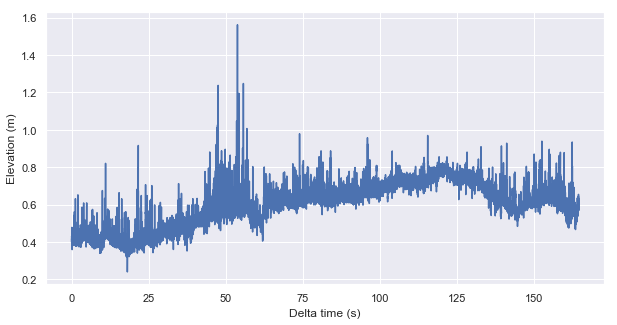

In [10]:
good = np.where((elev_1l < 100) )	#& (quality_1l == 1)
plt.figure(figsize=(10, 5))
plt.plot((delta_time_1l[good]-delta_time_1l[0])/(1.), elev_1l[good]) #delta_time_1l
plt.xlabel('Delta time (s)')
plt.ylabel('Elevation (m)')
plt.show()

In [11]:
def getATL07pd(fileT, beamT='gt1l'):
    # Beams: 
    f1 = h5py.File(fileT, 'r')
    #freeboard=f1['gt1l']['sea_ice_segments']['fbswath_fb_height'][:]
    lons=f1[beamT+'/sea_ice_segments/longitude'][:]
    lats=f1[beamT+'/sea_ice_segments/latitude'][:]

    delta_time_1l=f1[beamT+'/sea_ice_segments/delta_time'][:] #Number of seconds since the GPS epoch on midnight Jan. 6, 1980 
    atlas_epoch=f1['/ancillary_data/atlas_sdp_gps_epoch'][:] #Add this value to delta time parameters to compute full gps_seconds

    #Test conversion of delta_time to a calendar date
    temp = cGPS.convert_GPS_time(atlas_epoch[0] + delta_time_1l, OFFSET=0.0)

    year = temp['year'][:].astype('int')
    month = temp['month'][:].astype('int')
    day = temp['day'][:].astype('int')
    hour = temp['hour'][:].astype('int')
    minute = temp['minute'][:].astype('int')
    second = temp['second'][:].astype('int')



    elev=f1[beamT+'/sea_ice_segments/heights/height_segment_height'][:]
    ssh_flag=f1[beamT+'/sea_ice_segments/heights/height_segment_ssh_flag'][:] #Flag for potential leads, 0=sea ice, 1 = sea surface
    quality_1l=f1[beamT+'/sea_ice_segments/heights/height_segment_quality'][:] #1 for good fit, 0 for bad

    dF = pd.DataFrame({'elev':elev, 'lons':lons, 'lats':lats, 'ssh_flag':ssh_flag, 
                       'quality_flag':quality_1l, 'deltaTime':delta_time_1l, 'year':year, 'month':month, 'day':day, 'hour':hour, 'second':second},
                         columns=['elev','lons','lats', 'ssh_flag', 'quality_flag', 'deltaTime', 'year', 'month', 'day', 'hour', 'second'])
    return dF


dF=getATL07pd(ATL07_file, beamT='gt1l')
dF2=getATL07pd(ATL07_file, beamT='gt2l')

#dF['freeboard']>0)]
#dF = dF[(dF['freeboard']<10)]

# Reset row indexing
#dF=dF.reset_index(drop=True)

dF.head(5)

,elev,lons,lats,ssh_flag,quality_flag,deltaTime,year,month,day,hour,second
0,0.417146,168.261055,79.993832,0,0,2.813491e+07,2018,11,22,15,13
1,0.417146,168.261055,79.993832,0,0,2.813491e+07,2018,11,22,15,13
2,0.417146,168.261055,79.993832,0,0,2.813491e+07,2018,11,22,15,13
3,0.417139,168.261055,79.993832,0,0,2.813491e+07,2018,11,22,15,13
4,0.408681,168.260999,79.993788,0,0,2.813491e+07,2018,11,22,15,13


In [13]:
import xarray as xr
xr.Dataset(dF)
xr.Dataset(dF2)
#xr.merge([dF, dF2], compat='no_conflicts')

<xarray.Dataset>
Dimensions:       (dim_0: 110713)
Coordinates:
  * dim_0         (dim_0) int64 0 1 2 3 4 ... 110708 110709 110710 110711 110712
Data variables:
    elev          (dim_0) float32 0.39585683 0.39585683 ... 0.4437879 0.443385
    lons          (dim_0) float64 168.1 168.1 168.1 168.1 ... 161.4 161.4 161.4
    lats          (dim_0) float64 80.0 80.0 80.0 80.0 ... 69.66 69.66 69.66
    ssh_flag      (dim_0) int8 0 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0
    quality_flag  (dim_0) int8 0 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0
    deltaTime     (dim_0) float64 2.813e+07 2.813e+07 ... 2.814e+07 2.814e+07
    year          (dim_0) int64 2018 2018 2018 2018 2018 ... 2018 2018 2018 2018
    month         (dim_0) int64 11 11 11 11 11 11 11 11 ... 11 11 11 11 11 11 11
    day           (dim_0) int64 22 22 22 22 22 22 22 22 ... 22 22 22 22 22 22 22
    hour          (dim_0) int64 15 15 15 15 15 15 15 15 ... 15 15 15 15 15 15 15
    second        (dim_0) int64 13 13 13

In [ ]:
# The different beams have different number of dimensions. 
# How do we merge them into a joint array? 
# What value do we use to tag each beam to the same intiial pulse?
